# Multi-Layer Neural Network

**Due: Mondy, 10/10/2022, 2:15 PM**

Welcome to your fourth assignment. You will build a multi-layer neural network in this assignment.

Contents:

1. (10%) Exercise 2.1: Parameter initialization
2. (5%) Exercise 2.2: Linear transformation
3. (20%) Exercise 2.4: Forward propagation
4. (10%) Exerise 3.1: Derivatives of activation functions
5. (30%) Exercise 3.2: Gradients computation
6. (5%) Exercise 3.3: Gradient descent
7. (20%) Exercise 4: Training
Instructions:

- The code between the ### START CODE HERE ### and ### END CODE HERE ### comments will be graded.
- **Change variable names at your own risk. Make sure you understand what you are doing.**
- Avoid using for-loops and while-loops, unless you are explicitly asked to do so.

**You will learn:**
- Usage of Rectified Linear Unit (ReLU) activation function.
- Generalize number and dimension of the hidden layers.



## Review

**NOTE: math representations of forward and backward propogation has been updated. Please use the equations in the [updated slides](https://linzhanguca.github.io/_docs/applied_deep_learning-2022/0921/nn_p2.pdf) or the follows if you prefer no transopose in the forward propagation.**

To build your neural network, you will complete several "helper functions". These helper functions will be used to realize the forward and backward propagation when training a K-layer neural network. Each small helper function you will implement will have detailed instructions that will walk you through the necessary steps. Here is an outline of this assignment, you will:

- Initialize the parameters for K-layer neural network.
- Implement the forward propagation. 
     - Compute linear transformation $\mathbf{Z}^{[k]} = \mathbf{X}^{[k-1]} \cdot \mathbf{W}^{[k]} + \mathbf{b}^{[k]}$.
     - Compute activation: $X^{[k]} = g(\mathbf{Z}^{[k]})$.
     - Stack the "linear transfortmation" and "activation" to compute predictions in the final layer.
- Compute the cross entropy loss: 
    $$\mathcal{L(\hat{\mathbf{y}}, \mathbf{y}) = \frac{1}{M}\sum_{i=1}^M (-\mathbf{y}log(\hat{\mathbf{y}}) - (1 - \mathbf{y})log(1 - \hat{\mathbf{y}}))}$$
- Compute gradients of the parameters for backward propagation.
    $$d\mathbf{Z}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{Z}^{[k]}}} = d\mathbf{X}^{[k]} * g'^{[k]}(\mathbf{Z}^{[k]})$$
    $$d\mathbf{W}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{W}^{[k]}}} = \frac{1}{M}\mathbf{X}^{[k-1]\mathbf{T}} \cdot d\mathbf{Z}^{[k]}$$
    $$d\mathbf{b}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{b}^{[k]}}} = \frac{1}{M} \Sigma d\mathbf{Z}^{[k]}$$
    $$d\mathbf{X}^{[k-1]} = \frac{\partial{J}}{\partial{\mathbf{X}^{[k-1]}}} = d\mathbf{Z}^{[k]} \cdot \mathbf{W}^{[k]\mathbf{T}}$$
- Update the parameters using gradient descent algorithm.

## 1 - Prepare Dataset

First, let's import libraries that are neccissary. You may need to open a terminal, run `pip install opencv-python` to be able to use [OpenCV](https://opencv.org/) library: `import cv2`.

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils import *


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(4350)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load dataset. You can view any image by giving a valid index

y = 1, it's a cat picture


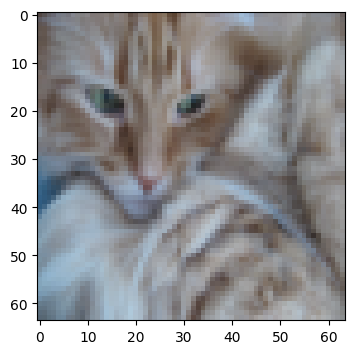

In [164]:
train_X, train_y, test_X, test_y, classes = load_data()
# show a picture from training dataset
index = 2
plt.imshow(train_X[index])
print(
    f"y = {train_y[index, 0]}, it's a {classes[train_y[index, 0]].decode('utf-8')} picture"
)

Preprocess the data, so that all the images are flattened and every pixel is standardized to a value in the range of 0 to 1.

In [165]:
# Explore your dataset
M_train = train_X.shape[0]
M_test = test_X.shape[0]
image_size = train_X.shape[1:]
print(f"Number of training examples: m_train = {M_train}")
print(f"Number of testing examples: m_test = {M_test}")
print(f"Size of each picture: {image_size}")

# Flatten and standardize
train_X_flatten = train_X.reshape(M_train, -1)
test_X_flatten = test_X.reshape(M_test, -1)
train_X = train_X_flatten / 255.0
test_X = test_X_flatten / 255.0
print(f"train_X's shape: {train_X.shape}")
print(f"test_X's shape: {test_X.shape}")
print(f"train_y's shape: {train_y.shape}")
print(f"test_y's shape: {test_y.shape}")


Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Size of each picture: (64, 64, 3)
train_X's shape: (209, 12288)
test_X's shape: (50, 12288)
train_y's shape: (209, 1)
test_y's shape: (50, 1)


## 2 - Forward Propagation
When training a neural network, you'll perform parameter initialization, linear transform, activation, loss computation for the forward propagation.

### 2.1 - Initialize Parameters for a K-layer neural network
For a K-layer neural network model, the structure of the parameters is determined by the dimension of the input data and dimensions of all the layers (hidden layers and output layer). 

#### **(10%) Exercise 2.1**: Parameter initialization
Complete `init_params()` function to realize parameter initialization. Input data can be represented as a matrix: `[number of examples, dimension of feature]`. Given the input features/variables dimension: `input_dim` and the dimensions of all the layers (hidden layers and output layer): `[1, 2, ..., k, ..., K]`, generate randomized parameters to represent the connections between the layers. Store the initialized parameters in a python dictionary.

> Hint: `np.random.randn(shape)*0.01` can be used to initialize the weights, and `np.zeros(shape)` can be used to intialize the bias.


In [166]:
def init_params(input_dim, layers_dims):
    """
    Argument:
    input_dim -- scalar, input feature dimension (X.shape[1])
    layers_dims -- list, dimensions of all layers
    
    Returns:
    parameters -- dictionary, contains parameters:
        Wk -- numpy array, weight matrix connects (k-1)th layer and kth layer
        bk -- numpy array, bias vector connects (k-1)th layer and kth layer
    """

    params = {}
    dims = [input_dim] + layers_dims
    for i in range(1, len(dims)):
        
        ### START CODE HERE ###
        params['W' + str(i)] = np.random.randn(dims[i - 1], dims[i]) * 0.01
        params['b' + str(i)] = np.zeros((1, dims[i]))
        
        ### END CODE HERE ###
        
        assert params['W' + str(i)].shape == (dims[i - 1], dims[i])
        assert params['b' + str(i)].shape == (1, dims[i])

    return params


# test
np.random.seed(4350)
parameters = init_params(8, [4, 2, 1])
print(f"W1 = {parameters['W1']}")
print(f"b1 = {parameters['b1']}")
print(f"W2 = {parameters['W2']}")
print(f"b2 = {parameters['b2']}")
print(f"W3 = {parameters['W3']}")
print(f"b3 = {parameters['b3']}")

W1 = [[-0.0097866   0.00059012 -0.01427151 -0.00276329]
 [-0.00452002 -0.00642133  0.00224894  0.00107208]
 [-0.00669298 -0.0005123   0.02440584 -0.00889387]
 [ 0.00033471 -0.00492237 -0.01517072 -0.00901276]
 [ 0.00409083 -0.01204107  0.00813648  0.01565679]
 [ 0.00361836  0.01152207 -0.00198383  0.01222088]
 [ 0.0094327   0.00909426  0.02394542  0.02829161]
 [-0.0018956  -0.00823652 -0.00024429 -0.01177393]]
b1 = [[0. 0. 0. 0.]]
W2 = [[ 0.00214078 -0.00504377]
 [ 0.02233779  0.00344896]
 [ 0.00667291 -0.0050118 ]
 [-0.00957994 -0.0052361 ]]
b2 = [[0. 0.]]
W3 = [[ 0.00593265]
 [-0.00457577]]
b3 = [[0.]]


**Expected output**:
       
```console
W1 = [[-0.0097866   0.00059012 -0.01427151 -0.00276329]
 [-0.00452002 -0.00642133  0.00224894  0.00107208]
 [-0.00669298 -0.0005123   0.02440584 -0.00889387]
 [ 0.00033471 -0.00492237 -0.01517072 -0.00901276]
 [ 0.00409083 -0.01204107  0.00813648  0.01565679]
 [ 0.00361836  0.01152207 -0.00198383  0.01222088]
 [ 0.0094327   0.00909426  0.02394542  0.02829161]
 [-0.0018956  -0.00823652 -0.00024429 -0.01177393]]
b1 = [[0. 0. 0. 0.]]
W2 = [[ 0.00214078 -0.00504377]
 [ 0.02233779  0.00344896]
 [ 0.00667291 -0.0050118 ]
 [-0.00957994 -0.0052361 ]]
b2 = [[0. 0.]]
W3 = [[ 0.00593265]
 [-0.00457577]]
b3 = [[0.]]
```

### 2.2 - Linear Transformation
Use the following equation to perform linear transformation:
$$\mathbf{Z}^{[k]} = \mathbf{X}^{[k-1]} \cdot \mathbf{W}^{[k]} + \mathbf{b}^{[k]}$$

#### **(5%) Exercise 2.2**: Linear transformation.
Complete `linear()` function to transoform the features in the previous layer (`X_j`) into the non-activated features in the next layer (`Z_k`) using parameters: `W_k` and `b_k`.

In [167]:
def linear(X_j, W_k, b_k):
    """
    linear transformation converts neurons in previous layer to neuron in current layer.

    Arguments:
        X_j -- numpy array, feature matrix of the (k-1)th layer. shape: (number_of_examples, previous_layer_dimension)
        W_k -- numpy array, weights matrix connects (k-1)th layer to kth layer. shape: (previous_layer_dimension, current_layer_dimension)
        b_k -- numpy array, bias vector connects (k-1)th layer to kth layer. shape: (1, current_layer_dimension)

    Returns:
        Z_k -- numpy array, linear transformed (pre-activation) featues matrix. shape: (number_of_examples, current_layer_dimension ) 
        cache -- dictionary {'X_j', 'W_k', 'b_k', 'Z_k'}, useful intermediate results for later usage.
    """

    ### START CODE HERE ###
    Z_k = np.dot(X_j, W_k) + b_k
    ### END CODE HERE ###
    
    assert Z_k.shape == (X_j.shape[0], W_k.shape[1])
    cache = {
        'X_j': X_j,
        'W_k': W_k,
        'b_k': b_k,
        'Z_k': Z_k,
    }

    return Z_k, cache

# test
np.random.seed(4350)
X = np.random.randn(3, 4)
W = np.random.randn(4, 2)
b = np.random.randn(1, 2)
Z, cache = linear(X, W, b)
print(f"pre-activation features: {Z}")
print(f"linear cache: {cache}")

pre-activation features: [[-0.5691033   2.86655348]
 [ 1.50009864  1.85049448]
 [ 0.69190761 -2.80338728]]
linear cache: {'X_j': array([[-0.97866006,  0.05901167, -1.42715059, -0.27632879],
       [-0.45200202, -0.64213329,  0.22489383,  0.10720757],
       [-0.66929759, -0.05123023,  2.44058435, -0.88938706]]), 'W_k': array([[ 0.03347135, -0.49223651],
       [-1.51707154, -0.9012758 ],
       [ 0.40908305, -1.20410713],
       [ 0.81364786,  1.56567891]]), 'b_k': array([[0.36183616, 1.15220702]]), 'Z_k': array([[-0.5691033 ,  2.86655348],
       [ 1.50009864,  1.85049448],
       [ 0.69190761, -2.80338728]])}


**Expected output**:

```console
pre-activation features: [[-0.5691033   2.86655348]
 [ 1.50009864  1.85049448]
 [ 0.69190761 -2.80338728]]
linear cache: {'X_j': array([[-0.97866006,  0.05901167, -1.42715059, -0.27632879],
       [-0.45200202, -0.64213329,  0.22489383,  0.10720757],
       [-0.66929759, -0.05123023,  2.44058435, -0.88938706]]), 'W_k': array([[ 0.03347135, -0.49223651],
       [-1.51707154, -0.9012758 ],
       [ 0.40908305, -1.20410713],
       [ 0.81364786,  1.56567891]]), 'b_k': array([[0.36183616, 1.15220702]]), 'Z_k': array([[-0.5691033 ,  2.86655348],
       [ 1.50009864,  1.85049448],
       [ 0.69190761, -2.80338728]])}
```

### 2.3 - Activation Functions
Activation functions add non-linear transformations toward the features. 
- Sigmoid
$$y = \sigma(x) = \frac{1}{1+e^{-x}}$$
- Hyperbolic Tangent
$$y = tanh(x) = \frac{e^x - e^{-x}}{e^x+e^{-x}}$$
- Rectified Linear Unit
$$y = ReLU(x) = 
    \begin{cases}
        0   & x \leq 0 \\
        x   & x > 0
    \end{cases}
$$

Linearly transformed features will be non-linearly activated by:
$$X^{[k]} = g(\mathbf{Z}^{[k]})$$
All the activation functions are either pre-built in `utils.py` or included in NumPy library, you don't have to do anything in this step. However, you can run the following code block to observe how different activation functions affect the features.


In [168]:
np.random.seed(4350)
Z = np.random.randn(1,4)
print(f"\noriginal feature: {Z}, \nsigmoid activated feature: {sigmoid(Z)} \ntanh activated feature: {np.tanh(Z)} \nrelu activated feature: {relu(Z)}")


original feature: [[-0.97866006  0.05901167 -1.42715059 -0.27632879]], 
sigmoid activated feature: [[0.27315774 0.51474864 0.19354304 0.43135405]] 
tanh activated feature: [[-0.75248527  0.05894327 -0.89108118 -0.2695039 ]] 
relu activated feature: [[0.         0.05901167 0.         0.        ]]


### 2.4 - Stack Linear and Activation 
Now, you can stack linear transformations and activations to implement any layer neural network's forward propagation.

#### **(20%) Exercise 2.4: Forward propagation**
Complete `forward()` function to implement the $K$-layer Neural Network. You will need to perform `linear()` then use any activation functions $K-1$ times, then follows the last `linear()` transformation followed by the `sigmoid()` activation.
You'll get a column vector, `yhat` with shape: `(number of example, 1)` in the end. 

> Tips:
- > Use the functions you had previously written 
- > Use a for loop to repeat `z=linear(x) -> x=relu(z)` or `z=linear(x) -> x=np.tanh(z)` or `z=linear(x) -> x=sigmoid(z)` (K-1) times
- > Don't forget to keep track of the intermediate results in each layer. You can use a nested dictionary: `caches` to store `cache` from each layer.

In [169]:
def forward(inputs, params, activation='relu'):
    """
    forward function loops linear and activation to tranform the original features into the probability of the predictions.

    Arguments:
        inputs -- numpy array, original feature matrix. shape: (number_of_examples, original_feature_dimension)
        params -- dictionary, stores weights and biases connects (k-1)th layer to kth layer.
        activation -- string, activation type for the hidden layers (exclude the final layer).

    Returns:
        yhat -- numpy array, column vector of the predicted probability of the classes. shape: (number_of_examples, 1) 
        caches -- nested dictionary {'layer1: {cache}', ... , 'layerK': {cache}}, stores all the intermediate results in each layer.
    """

    caches = {}
    num_layers = len(params) // 2

    ### START CODE HERE ###
    for k in range(1, num_layers):
        Z_k, cache = linear(inputs, params['W' + str(k)], params['b' + str(k)])
        if activation=='relu':
            X_k = relu(Z_k)
        elif activation=='tanh':
            X_k = np.tanh(Z_k)
        elif activation=='sigmoid':
            X_k = sigmoid(Z_k)
        else:
            X_k = Z_k
        inputs = X_k
        caches['layer' + str(k)] = cache

    Z_K, cache = linear(inputs, params['W' + str(k+1)], params['b' + str(k+1)]) # final layer linear transform
    yhat = sigmoid(Z_K)  # final layer activation 
    caches['layer' + str(num_layers)] = cache
    ### END CODE HERE ###
    
    assert yhat.shape == (inputs.shape[0], 1)

    return yhat, caches



# Test forward()
X = np.array([
        [-0.31178367, 0.72900392, 0.21782079, -0.8990918],
        [-2.48678065, 0.91325152, 1.12706373, -1.51409323],
        [1.63929108, -0.4298936, 2.63128056, 0.60182225],
        [-0.33588161, 1.23773784, 0.11112817, 0.12915125],
        [0.07612761, -0.15512816, 0.63422534, 0.810655],
    ]).T
parameters = {
    'W1': np.array([
        [0.35480861, 1.81259031, -1.3564758, -0.46363197, 0.82465384],
        [-1.17643148, 1.56448966, 0.71270509, -0.1810066, 0.53419953],
        [-0.58661296, -1.48185327, 0.85724762, 0.94309899, 0.11444143],
        [-0.02195668, -2.12714455, -0.83440747, -0.46550831, 0.23371059]
    ]).T,
    'b1': np.array([[1.38503523, -0.51962709, -0.78015214, 0.95560959]]),
    'W2': np.array([
        [-0.12673638, -1.36861282, 1.21848065, -0.85750144],
        [-0.56147088, -1.0335199, 0.35877096, 1.07368134],
        [-0.37550472, 0.39636757, -0.47144628, 2.33660781]
    ]).T,
    'b2': np.array([[1.50278553, -0.59545972, 0.52834106]]),
    'W3': np.array([[0.9398248, 0.42628539, -0.75815703]]).T,
    'b3': np.array([[-0.16236698]])}
y, caches = forward(X, parameters)
print(f"preds = {y}")
print(f"layer2 cache = {caches['layer2']}")

preds = [[0.03921668]
 [0.70498921]
 [0.19734387]
 [0.04728177]]
layer2 cache = {'X_j': array([[0.        , 0.        , 4.18500916, 5.05850802],
       [3.18040135, 0.        , 0.        , 0.        ],
       [0.4074501 , 3.18141622, 0.        , 0.        ],
       [0.        , 0.        , 2.72141639, 3.82321852]]), 'W_k': array([[-0.12673638, -0.56147088, -0.37550472],
       [-1.36861282, -1.0335199 ,  0.39636757],
       [ 1.21848065,  0.35877096, -0.47144628],
       [-0.85750144,  1.07368134,  2.33660781]]), 'b_k': array([[ 1.50278553, -0.59545972,  0.52834106]]), 'Z_k': array([[ 2.2644603 ,  6.3372257 , 10.3750834 ],
       [ 1.09971298, -2.38116247, -0.66591466],
       [-2.90298025, -4.11228806,  1.63635184],
       [ 1.54036335,  4.48582383,  8.17870168]])}


**Expected output:**
```console
preds = [[0.03921668]
 [0.70498921]
 [0.19734387]
 [0.04728177]]
layer2 cache = {'X_j': array([[0.        , 0.        , 4.18500916, 5.05850802],
       [3.18040135, 0.        , 0.        , 0.        ],
       [0.4074501 , 3.18141622, 0.        , 0.        ],
       [0.        , 0.        , 2.72141639, 3.82321852]]), 'W_k': array([[-0.12673638, -0.56147088, -0.37550472],
       [-1.36861282, -1.0335199 ,  0.39636757],
       [ 1.21848065,  0.35877096, -0.47144628],
       [-0.85750144,  1.07368134,  2.33660781]]), 'b_k': array([[ 1.50278553, -0.59545972,  0.52834106]]), 'Z_k': array([[ 2.2644603 ,  6.3372257 , 10.3750834 ],
       [ 1.09971298, -2.38116247, -0.66591466],
       [-2.90298025, -4.11228806,  1.63635184],
       [ 1.54036335,  4.48582383,  8.17870168]])}
```

### 2.5 - Loss Function

In modern deep learning community, cost and loss is used interchangebly. People no longer distinguish the example-wise loss and the total cost. It is convention that using loss function to represent the cost function we were using. You can use `loss_fn()` which is given below to compute the cross entropy loss and monitor the training procedure later. 

In [170]:
def loss_fn(preds, labels):
    loss = np.mean(-labels * np.log(preds) - (1-labels) * np.log(1-preds))

    return loss

## 3 - Backward Propagation

Back propagation is used to calculate the gradient of the loss function with respect to the parameters.


### 3.1 - Derivatives of Activation Functions
The derivative of the activation function is essential to compute the gradients.  
#### **(10%) Exercise 3.1: Derivatives of activation functions**
- Derivative of sigmoid function: 
    $$\sigma'(x) = \sigma(x)(1 - \sigma(x))$$
- Derivative of hyperbolic tangent function: 
    $$\tanh'(x) = 1 - \tanh^2(x)$$
- Derivative of relu function: 
    $$ReLU'(x) = 
        \begin{cases}
            0   & x \leq 0 \\
            1   & x > 0
        \end{cases}
    $$


In [171]:
### START CODE HERE ###
# sigmoid derivative
def d_sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    dydx = y * (1 - y)

    return dydx

# tanh derivative
def d_tanh(x):
    y = np.tanh(x)
    dydx = 1 - pow(y, 2)

    return dydx

# relu derivative
def d_relu(x):
    dydx = (x > 0) * 1
    return dydx
### END CODE HERE ###


### 3.2 Backward Loop
Now, you can compute the gradients of the weights and biases from the last layer to the first layer using the intermediate results and the derivatives of the activation functions.

#### **(30%) Exercise 3.2: Gradients computation**
Complete `backward()` function. Loop the following equations to compute the gradients of the parameters.
$$d\mathbf{Z}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{Z}^{[k]}}} = d\mathbf{X}^{[k]} * g'^{[k]}(\mathbf{Z}^{[k]})$$
$$d\mathbf{W}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{W}^{[k]}}} = \frac{1}{M}\mathbf{X}^{[k-1]\mathbf{T}} \cdot d\mathbf{Z}^{[k]}$$
$$d\mathbf{b}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{b}^{[k]}}} = \frac{1}{M} \Sigma d\mathbf{Z}^{[k]}$$
$$d\mathbf{X}^{[k-1]} = \frac{\partial{J}}{\partial{\mathbf{X}^{[k-1]}}} = d\mathbf{Z}^{[k]} \cdot \mathbf{W}^{[k]\mathbf{T}}$$


In [172]:
def backward(preds, labels, caches, activation='relu'):
    """
    backward() function computes gradients of the parameters from the last layer all the way back to the first layer.

    Arguments:
        preds -- numpy array, probabilities of predictions. shape: (number_of_examples, 1)
        labels -- numpy array, ground truth. shape: (number_of_examples, 1)
        caches -- nested dictionary. Stores all the intermediate results in each layer.
        activation -- string, activation type for the hidden layers (exclude the final layer).

    Returns:
        grads -- dictionary, gradients of the parameters in each layer 
    """

    assert preds.shape == labels.shape
    grads = {}
    K = len(caches)
    M = labels.shape[0]
    
    ### START CODE HERE ###
    dX_k = (-labels/preds) + ((1 - labels) / (1 - preds))
    for k in reversed(range(1, K + 1)):
        if k == K:
            dZ_k = dX_k * d_sigmoid(caches['layer' + str(k)]['Z_k'])   # final layer activation derivative
        else:
            if activation=='relu':
                dZ_k = dX_k * d_relu(caches['layer' + str(k)]['Z_k'])
            elif activation=='tanh':
                dZ_k = dX_k * d_tanh(caches['layer' + str(k)]['Z_k'])
            elif activation=='sigmoid':
                dZ_k = dX_k * d_sigmoid(caches['layer' + str(k)]['Z_k'])
            else:
                dZ_k = dX_k
        dW_k = 1/M * np.dot((caches['layer' + str(k)]['X_j']).T, dZ_k)
        db_k = 1/M * np.sum(dZ_k)
        dX_j = np.dot(dZ_k, dW_k.T)
        dX_k = dX_j
        grads['dW' + str(k)] = dW_k
        grads['db' + str(k)] = db_k
    ### END CODE HERE ###

    return grads


# Test backward()
yhat = np.array([[1.78862847, 0.43650985]]).T
y = np.array([[1, 0]]).T
caches = {
    'layer1': {
        'X_j': np.array([
            [0.09649747, -1.8634927],
            [-0.2773882, -0.35475898],
            [-0.08274148, -0.62700068],
            [-0.04381817, -0.47721803]
        ]).T,
        'W_k': np.array([
            [-1.31386475, 0.88462238, 0.88131804, 1.70957306],
            [0.05003364, -0.40467741, -0.54535995, -1.54647732],
            [0.98236743, -1.10106763, -1.18504653, -0.2056499]
        ]).T,
        'b_k': np.array([
            [1.48614836],
            [0.23671627],
            [1.02378514]
        ]).T,
        'Z_k': np.array([
            [-0.7129932, 0.62524497],
            [-0.16051336, -0.76883635],
            [-0.23003072, 0.74505627]
        ]).T
    },
    'layer2': {
        'X_j': np.array([
            [1.97611078, -1.24412333],
            [-0.62641691, -0.80376609],
            [-2.41908317, -0.92379202]
        ]).T,
        'W_k': np.array([[-1.02387576, 1.12397796, -0.13191423]]).T,
        'b_k': np.array([[-1.62328545]]),
        'Z_k': np.array([[0.64667545, -0.35627076]]).T,
    }
}
grads = backward(preds=yhat, labels=y, caches=caches)
print(grads)


{'dW2': array([[-0.39202432],
       [-0.13325855],
       [-0.04601089]]), 'db2': 0.15187860742650333, 'dW1': array([[0.15702021, 0.        , 0.01842906],
       [0.02989243, 0.        , 0.0035084 ],
       [0.05283185, 0.        , 0.00620074],
       [0.04021098, 0.        , 0.00471946]]), 'db1': -0.09415076513653933}


**Expected Output**

```console
{'dW2': array([[-0.39202432],
       [-0.13325855],
       [-0.04601089]]), 'db2': array([[0.15187861]]), 'dW1': array([[0.41010002, 0.        , 0.05283652],
       [0.07807203, 0.        , 0.01005865],
       [0.13798444, 0.        , 0.01777766],
       [0.10502167, 0.        , 0.0135308 ]]), 'db1': array([[-0.22007063,  0.        , -0.02835349]])}
```


### 3.3 - Update Parameters

In this section you will update the parameters of the model, using gradient descent: 
$$ W^{[k]} = W^{[k]} - \alpha \text{ } dW^{[k]} $$
$$ b^{[k]} = b^{[k]} - \alpha \text{ } db^{[k]} $$
where $\alpha$ is the learning rate. After computing the updated parameters, store them back to the parameters dictionary. 

#### **(5%) Exercise 3.3:** Gradient Descent
Complete `update()` to update your parameters using gradient descent.
> Hint: use `str()` to convert integers into strings.


In [173]:
def update(params, grads, learning_rate):
    """
    backward() function computes gradients of the parameters from the last layer all the way back to the first layer.

    Arguments:
        params -- dictionary, old parameters.
        grads -- dictionary, gradients of the parameters in each layer 
        learning_rate -- scalar, controls the speed of training.

    Returns:
        params -- dictionary, updated parameters.
    """

    K = len(params) // 2

    ### START CODE HERE ###
    for k in range(K):
        params['W' + str(k + 1)] = params['W' + str(k + 1)] - (learning_rate * grads['dW' + str(k + 1)])
        params['b' + str(k + 1)] = params['b' + str(k + 1)] - (learning_rate * grads['db' + str(k + 1)])
    ### END CODE HERE ###

    return params


# test
np.random.seed(4350)
W1 = np.random.randn(4, 3)
b1 = np.random.randn(1, 3)
W2 = np.random.randn(3, 1)
b2 = np.random.randn(1, 1)
parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
np.random.seed(3)
dW1 = np.random.randn(4, 3)
db1 = np.random.randn(1, 3)
dW2 = np.random.randn(3, 1)
db2 = np.random.randn(1, 1)
grads = {"dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}

parameters = update(parameters, grads, 0.1)
print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-1.1575229   0.01536069 -1.43680034]
 [-0.08997952 -0.4242632  -0.60665739]
 [ 0.23316797  0.16990764 -0.66491577]
 [-0.00350843  2.57197082 -0.9778493 ]]
b1 = [[-0.05466045 -0.66319382 -1.52207491]]
W2 = [[-0.86080806]
 [ 0.46361905]
 [-1.0494594 ]]
b2 = [[0.71541112]]


**Expected Output**:

```console
W1 = [[-1.1575229   0.01536069 -1.43680034]
 [-0.08997952 -0.4242632  -0.60665739]
 [ 0.23316797  0.16990764 -0.66491577]
 [-0.00350843  2.57197082 -0.9778493 ]]
b1 = [[-0.05466045 -0.66319382 -1.52207491]]
W2 = [[-0.86080806]
 [ 0.46361905]
 [-1.0494594 ]]
b2 = [[0.71541112]]
```


## 4 - Train a K-layer Neural Network
Put up together forward and backward propagation and train a neural network with any number of layers

#### **(20%) Exercise 4.1:** Training
Complete `train()` function. You can tune your model by using different `layers_dims`, `activation`, `learning_rate`, `num_iterations`.

Cost after iteration 100: 0.6555780565485829
Cost after iteration 200: 0.6467866358202986
Cost after iteration 300: 0.6446735463625192
Cost after iteration 400: 0.6441497089537143
Cost after iteration 500: 0.6440175565534676
Cost after iteration 600: 0.6439838548537246
Cost after iteration 700: 0.6439751573311555
Cost after iteration 800: 0.6439728445709964
Cost after iteration 900: 0.6439721667673128
Cost after iteration 1000: 0.6439719084130557
Cost after iteration 1100: 0.6439717578681963
Cost after iteration 1200: 0.6439716352769194
Cost after iteration 1300: 0.6439715201106945
Cost after iteration 1400: 0.6439714070077842
Cost after iteration 1500: 0.6439712946368293
Cost after iteration 1600: 0.6439711826649969
Cost after iteration 1700: 0.6439710709350953
Cost after iteration 1800: 0.643970959331638
Cost after iteration 1900: 0.6439708479663392
Cost after iteration 2000: 0.6439707368387049
Cost after iteration 2100: 0.6439706260632971
Cost after iteration 2200: 0.643970515527052

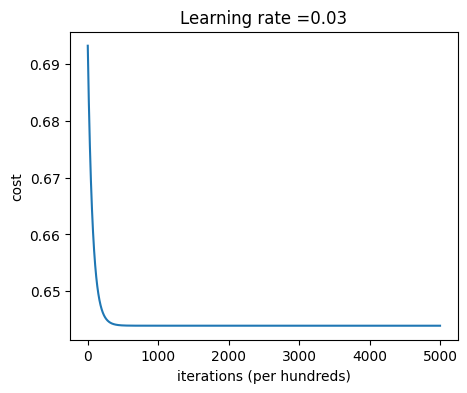

In [174]:
def train(
    inputs, labels, params, activation='relu', learning_rate=0.0075, num_iterations=3000, print_cost=False
):
    """
    train() function performs forward and backward propagation to obtain updated parameters.

    Arguments:
        inputs -- numpy array, original feature matrix. shape: (number_of_examples, original_feature_dimension)
        labels -- numpy array, ground truth. shape: (number_of_examples, 1)
        params -- dictionary, stores weights and biases connects (k-1)th layer to kth layer.
        activation -- string, activation type for the hidden layers (exclude the final layer).
        learning_rate -- scalar, controls the speed of training.
        num_iterations -- scalar, numbers of training loops.
        print_cost -- bool, to print averaged loss in every 100 iterations or not.

    Returns:
        params -- dictionary, updated parameters.
    """

    grads = {}
    losses = []  # to keep track of the cost

    ### START CODE HERE ###
    for i in range(1, num_iterations+1):
        preds, caches = forward(inputs, params, activation)
        loss = loss_fn(preds, labels)
        grads = backward(preds, labels, caches, activation)
        params = update(params, grads, learning_rate)
        if print_cost and not (i % 100):
            print(f"Cost after iteration {i}: {np.squeeze(loss)}")
        losses.append(loss)
    ### END CODE HERE ###

    plt.plot(np.squeeze(losses))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title('Learning rate =' + str(learning_rate))
    # plt.show()

    return params


# Training
np.random.seed(4350)

### START CODE HERE ###
layers_dims = [8, 4, 1]
params = init_params(train_X.shape[1], layers_dims)  # init params

### END CODE HERE ###

params = train(
    train_X,
    train_y,
    params,
    activation='relu',
    num_iterations=5000,
    learning_rate=0.03,
    # num_iterations=13500,
    # learning_rate=0.01,
    print_cost=True
)

# Evaluation
train_preds, _ = forward(train_X, params)
train_preds = train_preds > 0.5
train_accuracy = np.sum(train_preds == train_y) / train_y.shape[0]
print(f"train_accuracy: {train_accuracy}")
test_preds, _ = forward(test_X, params)
test_preds = test_preds > 0.5
test_accuracy = np.sum(test_preds == test_y) / test_y.shape[0]
print(f"test_accuracy: {test_accuracy}")

**Expected Output**:

```console
Cost after iteration 100: 0.6555767625124284
Cost after iteration 200: 0.6467861650031772
Cost after iteration 300: 0.644673251343426
Cost after iteration 400: 0.6441493622996151
Cost after iteration 500: 0.6440171212577572
Cost after iteration 600: 0.6439833108092134
Cost after iteration 700: 0.6439744892856368
Cost after iteration 800: 0.6439720291615333
Cost after iteration 900: 0.6439711781357069
Cost after iteration 1000: 0.6439707173668276
Cost after iteration 1100: 0.6439703266137381
Cost after iteration 1200: 0.6439699125428286
Cost after iteration 1300: 0.6439694437892591
Cost after iteration 1400: 0.643968904782073
Cost after iteration 1500: 0.6439682828411811
Cost after iteration 1600: 0.643967564970407
Cost after iteration 1700: 0.643966720541062
Cost after iteration 1800: 0.6439657237669492
Cost after iteration 1900: 0.6439645425002293
Cost after iteration 2000: 0.6439631343005117
Cost after iteration 2100: 0.6439614362611531
Cost after iteration 2200: 0.6439593737815364
Cost after iteration 2300: 0.6439567865212631
Cost after iteration 2400: 0.6439534598397181
Cost after iteration 2500: 0.6439492745389768
...
Cost after iteration 4700: 0.25480665125699675
Cost after iteration 4800: 0.24463425857274818
Cost after iteration 4900: 0.1242258171168041
Cost after iteration 5000: 0.29679326419487606

train_accuracy: 0.7607655502392344
test_accuracy: 0.78
```


You'll notice the training accuracy is relatively low and the later stage of the training is very fluctuated. The loss has the trend of getting smaller. The test accuracy is relatively high (compare to 68% in assignment 2). These are the good signs. Can you adjust the hyperparameters to train a better model?

## Test with Your Own Images
You can upload new images to `/images` folder and test them using the model you've trained.

[[0.]]
Your model predicts a non-cat picture


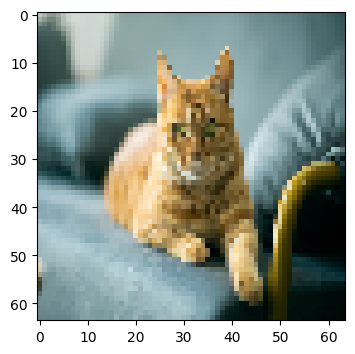

In [176]:
# Define prediction function
def predict(X, params):
    """
    This function is used to predict the results of a K-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    pred -- predicted classes for the given data X
    """
    
    M = X.shape[0]
    yhat, caches = forward(X, params, activation='relu')
    pred = (yhat > 0.5).astype(np.float32)
        
    return pred


# Make 
file = "cat2.jpg"   # change this to the name of your image file 
# preprocess the image to fit your algorithm.
fname = "images/" + file
im = cv2.imread(fname)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
imresize = cv2.resize(im_rgb, image_size[:-1])
imfloat = imresize/255.
imflatten = imfloat.reshape(1,-1)
pred_cls = predict(imflatten, params)
print(pred_cls)
plt.imshow(imresize)
print(f"Your model predicts a {classes[int(np.squeeze(pred_cls))].decode('utf-8')} picture")


## Congrats on finishing this assignment! 